In [369]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
import pandas as pd
import random
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.models import resnet50, ResNet50_Weights

## Dataset and Overview

In [51]:
train_path = 'data/train/'

In [73]:
# Train data split
labels = os.listdir('data/train/')
print('Number of images for each class:')
for label in labels:
    print(str(label) + ": " + str(len(os.listdir(train_path + str(label)))))

Number of images for each class:
malignant: 4605
benign: 5001


In [107]:
dataset = ImageFolder(train_path, transform=transforms.ToTensor())
# Class label as index
classidx = dataset.class_to_idx
pd.DataFrame(classidx.values(), index=classidx.keys(), columns=['label'])

,label
benign,0
malignant,1


In [187]:
# Check image sizes
rand_index = random.sample(range(len(dataset)), 10)
img, __ = dataset[0]
img_size = img.shape
for i in rand_index: 
    rand_img, __ = dataset[i]
    assert(rand_img.shape == img_size)
print("Image size: " + str(img_size))

Image size: torch.Size([3, 300, 300])


In [189]:
ben_rand_index = random.sample(range(5001), 4) # get 4 benign images
mal_rand_index = random.sample(range(5002,len(dataset)), 4) # get 4 malignant images

In [193]:
def form_image(image):
    '''Tensor shapes are (C, H, W), but imshow() expects (H, W, C), so it is necessary to rearrage it first'''
    return image.permute(1, 2, 0)

Text(0, 0.5, 'malignant')

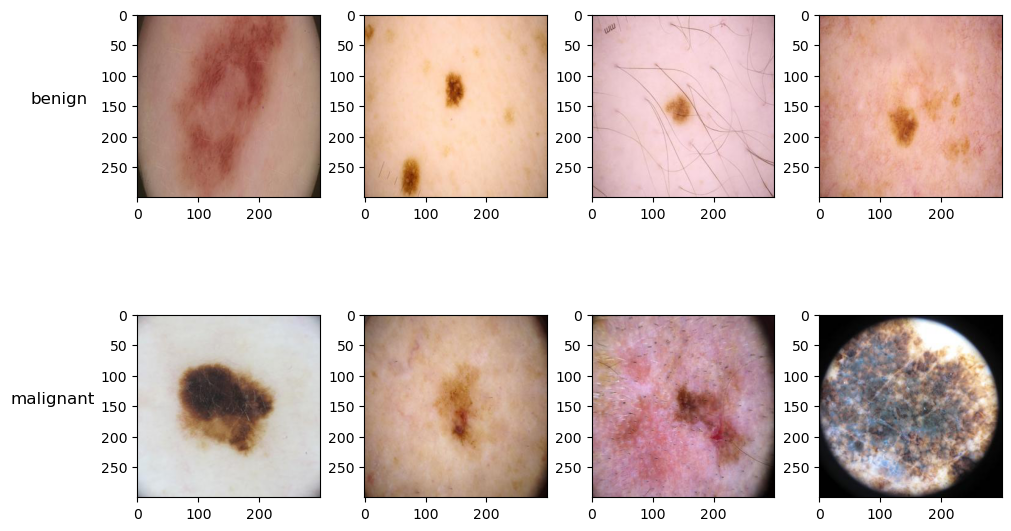

In [293]:
# Display images from train data
fig, axs = plt.subplots(2,4, figsize=(10,6), constrained_layout=True)
# benign
axs[0][0].imshow(form_image(dataset[ben_rand_index[0]][0]))
axs[0][1].imshow(form_image(dataset[ben_rand_index[1]][0]))
axs[0][2].imshow(form_image(dataset[ben_rand_index[2]][0]))
axs[0][3].imshow(form_image(dataset[ben_rand_index[3]][0]))

# malignant
axs[1][0].imshow(form_image(dataset[mal_rand_index[0]][0]))
axs[1][1].imshow(form_image(dataset[mal_rand_index[1]][0]))
axs[1][2].imshow(form_image(dataset[mal_rand_index[2]][0]))
axs[1][3].imshow(form_image(dataset[mal_rand_index[3]][0]))

axs[0,0].set_ylabel('benign', rotation=0, fontsize=12, labelpad=30)
axs[1,0].set_ylabel('malignant', rotation=0, fontsize=12, labelpad=35)

## Preprocessing

In [419]:
class DatasetWrapper(Dataset):
    """Sourced from https://discuss.pytorch.org/t/torch-utils-data-dataset-random-split/32209/4
    A wrapper class to enable transformations and augmentations on the train images"""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [423]:
# For resnet50, input is 224x224, reload dataset with this applied
val_transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor()])
# Define transformation for augments
train_transform = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.RandomRotation(30),
                                     transforms.ToTensor()])

dataset = ImageFolder(train_path, transform=None)

# split
train, val = random_split(dataset, [0.8, 0.2])

# apply resizing and transformations
train = DatasetWrapper(train, transform=train_transform)
val = DatasetWrapper(val, transform=val_transform)

## Transfer Learning -- ResNet50
### Only tune final layer

In [431]:
# Load images into batches
train_load = DataLoader(train, batch_size=32, shuffle=True)
val_load = DataLoader(val, batch_size=32)

In [472]:
res50weights = ResNet50_Weights.DEFAULT
# preprocess = res50weights.transforms()

# apply transformations and preprocessing
# img_transformed = preprocess(img)

# initialize model
model = resnet50(weights=res50weights)

# replace final layer
model.fc = nn.Linear(2048, 1)

In [474]:
# try to increase processing speed utilizing available resources
if torch.backends.mps.is_available():
    device = torch.device("mps") # for apple M1/M2 chips
elif torch.cuda.is_available():
    device = torch.device("cuda") # for NVIDIA GPU
else:
    device = torch.device("cpu") # else use cpu

model = model.to(device)

for param in model.parameters():
    param.requires_grad = False # Freeze all layers to prevent training

for param in model.parameters():
    param.requires_grad = True # Leave final layer unfrozen

In [476]:
# Define loss function -- use logits for binary classificatino
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
epochs = 3

for epoch in range(epochs):
    model.train() # set model to train mode
    total_loss = 0
    for imgs, labels in train_load:
        total_loss = 0
        

In [498]:
def train_model(model, train_load, lossfn, optimizer, device, num_epochs=3, ):
    model.to(device)
    
    for epoch in range(num_epochs):

        model.train() # set model to train mode
        total_loss = 0

        for imgs, labels in train_load:

            imgs = imgs.to(device) # put images on same device as model
            labels = labels.float().unsqueeze(1).to(device) # adjust type and shape for BCE

            outputs = model(imgs) # raw predictions
            loss = lossfn(outputs, labels) # sigmoid/BCE to evaluate predictions to generate loss

            optimizer.zero_grad() 
            loss.backward() # backprop
            optimizer.step() # adjust weights

            total_loss += loss.item() # add to total loss for epoch

        print(f"Epoch {epoch + 1} \t loss: {total_loss / len(train_load)}") # avg loss per batch

    return model

In [500]:
model = train_model(model, train_load, loss, optimizer, device)

before 4 loop
in 1 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in 2 4 loop
in

In [496]:
print(device)

mps


## Validation set

In [501]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_load:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds.squeeze() == labels).sum().item()
        total += labels.size(0)

print(f"Validation Accuracy: {correct / total:.2%}")

Validation Accuracy: 93.96%


In [504]:
# Save model to disk
# torch.save(model.state_dict(), 'resnet50v1.pth')

In [516]:
model1 = resnet50()
model1.fc = nn.Linear(2048, 1)
model1.load_state_dict(torch.load('resnet50v1.pth', weights_only=True))

<All keys matched successfully>

In [524]:
model1.eval()
correct = 0
total = 0

model1.to(device)

with torch.no_grad():
    for images, labels in val_load:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model1(images)
        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds.squeeze() == labels).sum().item()
        total += labels.size(0)

print(f"Validation Accuracy: {correct / total:.2%}")

Validation Accuracy: 93.96%
